<a href="https://colab.research.google.com/github/kahhotan/Time-Series/blob/main/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VIX Time Series

This project attempts to predict the movement of VIX, using various time series models. The dataset is taken from FRED (Federal Reserve Economic Data), so minimal cleaning is expected. Data accuracy can be assumed to be high. We have extracted data from the year 1990. However, the calculation for VIX changed in 2003, therefore we would only use data from 2004 onwards.

Our approach to this problem would include

1. Data Visualisation
2. Stationarity Test
3. Model Building
4. Prediction/Forecasting

We would then compare the RMSE (Root Mean Square Error) to select the best model






Loading Libraries

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from matplotlib import pyplot

%matplotlib inline

Load Dataset

In [10]:
#Load dataframe
vix = pd.read_csv("/content/VIX.csv", index_col = 'Date', parse_dates = ['Date'])

In [18]:
vix.sort_index(inplace=True)

Data Exploration and Preprocessing

In [19]:
#Data exploration
vix.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-03,14.91,15.050000,14.400000,14.440000,14.440000,0
2004-01-04,16.76,17.250000,16.650000,16.650000,16.650000,0
2004-01-06,16.60,16.959999,16.190001,16.299999,16.299999,0
2004-01-07,14.74,15.570000,14.410000,15.200000,15.200000,0
2004-01-09,15.39,15.390000,14.720000,14.910000,14.910000,0


In [20]:
vix = vix.loc['2004':] #Select 2004 onwards due to calculation changes in VIX

In [21]:
vix.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4406.000000,4406.000000,4406.000000,4406.000000,4406.000000,4406.0
mean,19.030563,19.962099,18.102987,18.916391,18.916391,0.0
std,9.165392,9.852950,8.446091,9.117493,9.117493,0.0
min,9.010000,9.310000,8.560000,9.140000,9.140000,0.0
25%,13.232500,13.760000,12.752500,13.160000,13.160000,0.0
50%,16.185001,16.900000,15.460000,16.090000,16.090000,0.0
75%,21.925000,22.997500,20.870001,21.637499,21.637499,0.0
max,82.690002,89.529999,72.760002,82.690002,82.690002,0.0


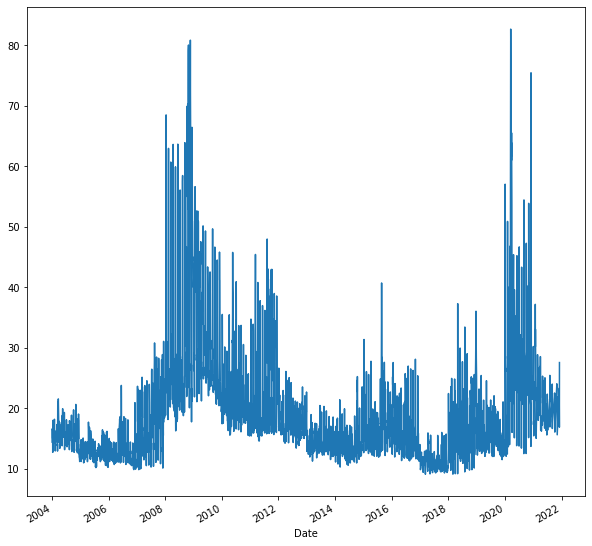

In [31]:
vix ['Adj Close'].plot(figsize = (10,10))

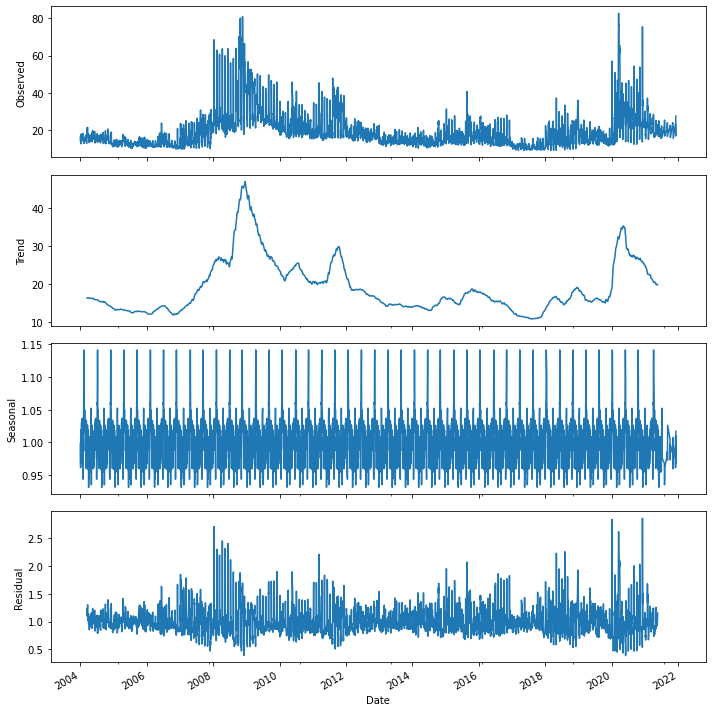

In [30]:
#Observing Time Series Components

plt.rcParams['figure.figsize'] = (10,10)
components = seasonal_decompose(vix ['Adj Close'], model='mul', freq = 100)
components.plot();

As we break down the time series components, we can see the spikes in year 2008 as well as 2020. This indicates that 

In [ ]:
df.plot(figsize = (30,10))
df_rolling.plot(figsize = (30,10), color = 'red')

In [ ]:
#Statistical stationary Test

vix_adf = adfuller(vix['AdjClose'])

In [ ]:
#Null: It is non stationary
#Alt: It is stationary

def adfuller_test(AdjClose):
    result = adfuller(AdjClose)
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Reject the null hypothesis. Time Series has no unit root and is stationary")
    else:
        print("Time series has a unit root, indicating it is non-stationary ")
        
adfuller_test(vix['AdjClose'])


Establishing Baseline Model

In [ ]:
#Persistence Algorithm (Naive forecast)

baseline = pd.DataFrame(vix_ts) #created 'baseline' as 'df_ts'(numpy.ndarray type) does not contain 'shift' function

In [ ]:
#Create laggard dataset (t+1)

vix_laggard = pd.concat([baseline, baseline.shift(1)], axis = 1)

In [ ]:
vix_laggard.head()

In [ ]:
vix_laggard.columns = ['Actual', 'Lag']

In [ ]:
vix_laggard.head()

In [ ]:
vix_test = vix_laggard[1:]

In [ ]:
vix_test.head()

In [ ]:
vix_test.tail()

In [ ]:
vix_mse = mean_squared_error(vix_test.Actual, vix_test.Lag)

In [ ]:
vix_mse

In [ ]:
np.sqrt(vix_mse)

ARIMA (p,d,q) Model

In [ ]:
#Stationary Test

test_result=adfuller(vix['AdjClose'])

In [ ]:
#Autocorrelation
#plot acf is to identify parameter q

plot_acf(vix)

In [ ]:
#Partial Autocorrelation
plot_pacf(vix)

In [ ]:
#Splitting into test and training set

vix.size

In [ ]:
vix_train = vix[0:5500]
vix_test = vix[5500:7938]

In [ ]:
vix_train.size

In [ ]:
vix_test.size

In [ ]:
vix_arima = ARIMA (vix_train, order = (4,0,2))

In [ ]:
vix_arima_fit = vix_arima.fit()

In [ ]:
vix_arima_fit.aic

In [ ]:
vix_forecast = vix_arima_fit.forecast(steps = 2438)[0]

In [ ]:
vix_forecast

In [ ]:
vix_test

In [ ]:
np.sqrt(mean_squared_error(vix_test, vix_forecast))